# Airbnb Seattle Data Exploration

## Introduction

Airbnb is a home-sharing/renting platform for those who would like to whether stay in a flat/villa/bungalow etc. or rent their room/flat for a specified period. Even though there are guidelines on how to set prices on a listing as a host, there is no set rule. Airbnb has a feature called 'smart pricing' that could be used as starting point to set prices for a listing, especially for less experienced hosts. 

## Business Understanding

In this post, we will take a look at the Seattle listings dataset that were scraped on the 25th of October 2020 to answer some of the following questions, which we derived after having a closer look through the data:

- __Question set 1:__ Which features are highly correlated with price?
- __Question set 2:__ Do reviews have any effect on the price? Which factors affect the overall rating? Is it profitable to have the high rating?
- __Question set 3:__ What are the most common property and room types that are listed? How are the prices distributed amongst them?

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import myutils as myu
import re
%matplotlib inline

#### Utility Functions

In [286]:
def convert_to_binary(df, col):
    """Converts binary values t and f into 1 and 0 values and nan values into 0."""
    df[col] = df[col].replace({"t": 1, "f": 0, "nan": "NaN"}).fillna(0)
    return df[col]

def create_dummy_cols(df, cat_cols, dummy_na):
    """Creates dummy variables from categorical variables"""
    for col in cat_cols:
        try:
            dummy_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)
            df=pd.concat([df.drop(col, axis=1), dummy_df], axis=1)
        except:
            continue
    return df

def map_substring(s, dict_map):
    """Map dictionary values to keys if a column contains the dictionary keys"""
    for key in dict_map.keys():
        if key in s.lower(): return dict_map[key]
    return 'other'

def remove_special_char(df, col):
    """Removes special characters such as % and $ from numeric variables and converts them into float"""
    df[col] = df[col].replace(regex = True, to_replace = r'[^0-9.\-]', value=r'')
    df[col] = df[col].astype("float")
    return df[col]


def plot_heatmap(df, figsize=(20,20)):
    """
    Creates a heatmap of correlations between features in the df.
    """
    # Set the style of the visualization
    sns.set(style="white")
    # Create a covariance matrix
    corr = df.corr()
    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());



In [287]:
# Adjust the figure sizes
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 100 

In [288]:
# import sys
# !{sys.executable} -m pip install unidecode

In [289]:
# Read the data frame
listing_df = pd.read_csv('../data/seattle_listings.csv.gz') 

## Data Understanding

In [290]:
listing_df.shape

(4335, 74)

In [291]:
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20201025051148,2020-10-25,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",Madrona is a hidden gem of a neighborhood. It ...,https://a0.muscache.com/pictures/02973ad3-a7a3...,2536,https://www.airbnb.com/users/show/2536,...,10.0,10.0,10.0,STR-OPLI-19-002837,f,2,2,0,0,0.22
1,9419,https://www.airbnb.com/rooms/9419,20201025051148,2020-10-25,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,https://www.airbnb.com/users/show/30559,...,10.0,10.0,10.0,str-opli-19-003039,f,8,0,8,0,1.19
2,9531,https://www.airbnb.com/rooms/9531,20201025051148,2020-10-25,The Adorable Sweet Orange Craftsman,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,https://a0.muscache.com/pictures/30470355/052c...,31481,https://www.airbnb.com/users/show/31481,...,10.0,10.0,10.0,STR-OPLI-19-002182,f,2,2,0,0,0.37
3,9534,https://www.airbnb.com/rooms/9534,20201025051148,2020-10-25,The Coolest Tangerine Dream MIL!,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,https://a0.muscache.com/pictures/30476721/0751...,31481,https://www.airbnb.com/users/show/31481,...,10.0,10.0,10.0,STR-OPLI-19-002182,f,2,2,0,0,0.50
4,9596,https://www.airbnb.com/rooms/9596,20201025051148,2020-10-25,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...",https://a0.muscache.com/pictures/665252/102d18...,14942,https://www.airbnb.com/users/show/14942,...,9.0,10.0,9.0,STR-OPLI-19-002622,f,2,2,0,0,0.85


In [292]:
listing_df.price.head(10)

0    $295.00
1     $55.00
2    $155.00
3    $125.00
4    $100.00
5     $81.00
6     $50.00
7    $280.00
8     $50.00
9    $156.00
Name: price, dtype: object

In [293]:
listing_df.amenities.head(10)

0    ["Children\u2019s books and toys", "Iron", "Ha...
1    ["Iron", "Hangers", "Lock on bedroom door", "H...
2    ["Iron", "TV", "Hangers", "Cable TV", "Private...
3    ["Conditioner", "Iron", "TV", "Hangers", "Cabl...
4    ["Iron", "TV", "Hangers", "Cable TV", "Hair dr...
5    ["Bathtub", "Children\u2019s books and toys", ...
6    ["Free street parking", "Hot water", "Wifi", "...
7    ["Conditioner", "Iron", "TV", "Hangers", "Hair...
8    ["Wifi", "Dryer", "Kitchen", "Indoor fireplace...
9    ["Iron", "TV", "Shared hot tub", "Hair dryer",...
Name: amenities, dtype: object

We have 4335 listings and 74 features, which are not in a clean format. It shows the overall price advertised by the host rather than the average price paid by the guests. However, we will use this dataset as a proof of concept rather than the source of truth. We begin our analysis with data preparation steps to re-format the features that would be informative for building a model and predict the price given the characteristics of the bespoke listings.

In [294]:
# Show the missing values with their percentages
percent_missing = listing_df.isnull().sum() * 100 / len(listing_df)
missing_value_df = pd.DataFrame({'column_name': listing_df.columns,
                                 'percent_missing': percent_missing})

In [295]:
missing_value_df[percent_missing > 0]

,column_name,percent_missing
description,description,0.276817
neighborhood_overview,neighborhood_overview,29.757785
host_name,host_name,0.184544
host_since,host_since,0.184544
host_location,host_location,0.322953
host_about,host_about,28.396770
host_response_time,host_response_time,13.241061
host_response_rate,host_response_rate,13.241061
host_acceptance_rate,host_acceptance_rate,8.650519
host_is_superhost,host_is_superhost,0.184544


## Data Preparation

In [296]:
# Show the list of completely missing values
listing_df.columns[listing_df.isnull().mean()==1]

Index(['bathrooms', 'calendar_updated'], dtype='object')

In [297]:
listing_df.columns[(listing_df.nunique()<=1)]

Index(['scrape_id', 'last_scraped', 'bathrooms', 'calendar_updated',
       'has_availability', 'calendar_last_scraped'],
      dtype='object')

We remove all the columns that 
- have the same constant value for the entire dataset :
   - 'scrape_id', 'has_availability', 'calendar_last_scraped'
- are completely missing:
   - 'bathrooms' and 'calendar_updated'
- contain URLs (as we are not going to do any text analytics at this analysis)

In [298]:
# Create a list to remove constant and missing values
# and those contain URL
remove_list = listing_df.columns[(listing_df.nunique()<=1) 
                                 | (listing_df.columns.str.contains('url'))
                                 | (listing_df.isnull().mean()==1)
                                ].tolist()

In [299]:
remove_list

['listing_url',
 'scrape_id',
 'last_scraped',
 'picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url',
 'bathrooms',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped']

In [300]:
# We add 'last_scraped' variable to our dataframe 
# It will be used to create additional variables later
remove_list.remove('last_scraped')

In [301]:
listing_df = listing_df.drop((listing_df.columns[listing_df.isnull().mean()==1]).union(remove_list),axis=1)

In [302]:
listing_df.shape

(4335, 64)

In [303]:
listing_df.iloc[:, :20].head()

,id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,2318,2020-10-25,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",Madrona is a hidden gem of a neighborhood. It ...,2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within a day,100%,78%,t,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
1,9419,2020-10-25,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...",30559,Angielena,2009-08-09,"Seattle, Washington, United States",I am a visual artist who is the director of ...,within a few hours,100%,89%,t,Georgetown,8.0,8.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
2,9531,2020-10-25,The Adorable Sweet Orange Craftsman,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,31481,Cassie,2009-08-13,"Seattle, Washington, United States",The Sweet Orange reflects my passion and zest ...,within a day,100%,64%,t,The Junction,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t
3,9534,2020-10-25,The Coolest Tangerine Dream MIL!,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,31481,Cassie,2009-08-13,"Seattle, Washington, United States",The Sweet Orange reflects my passion and zest ...,within a day,100%,64%,t,The Junction,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t
4,9596,2020-10-25,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...",14942,Joyce,2009-04-26,"Seattle, Washington, United States",I am a therapist/innkeeper.I know my city well...,within a few hours,90%,94%,f,Wallingford,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t


In [304]:
listing_df.iloc[:, 21:40].head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm
0,Madrona,Central Area,47.61082,-122.29082,Entire house,Entire home/apt,9,2.5 baths,4.0,4.0,"[""Children\u2019s books and toys"", ""Iron"", ""Ha...",$295.00,1,1125,1,2,1125,1125,1.0
1,Georgetown,Other neighborhoods,47.55017,-122.31937,Private room in apartment,Private room,2,3 shared baths,1.0,2.0,"[""Iron"", ""Hangers"", ""Lock on bedroom door"", ""H...",$55.00,2,180,2,2,180,180,2.0
2,Fairmount Park,West Seattle,47.55539,-122.38474,Entire house,Entire home/apt,4,1 bath,2.0,3.0,"[""Iron"", ""TV"", ""Hangers"", ""Cable TV"", ""Private...",$155.00,28,1125,28,28,1125,1125,28.0
3,Fairmount Park,West Seattle,47.55624,-122.38598,Entire guest suite,Entire home/apt,3,1 bath,2.0,2.0,"[""Conditioner"", ""Iron"", ""TV"", ""Hangers"", ""Cabl...",$125.00,5,1125,5,5,1125,1125,5.0
4,Wallingford,Other neighborhoods,47.65479,-122.33652,Entire apartment,Entire home/apt,4,1 bath,1.0,4.0,"[""Iron"", ""TV"", ""Hangers"", ""Cable TV"", ""Hair dr...",$100.00,4,60,4,4,1125,1125,4.0


In [305]:
listing_df.iloc[:, 41:60].head()

,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count
0,0,0,26,26,32,4,0,2008-09-15,2020-02-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-OPLI-19-002837,f,2
1,29,59,89,364,148,2,0,2010-07-30,2019-12-27,93.0,10.0,10.0,10.0,10.0,10.0,10.0,str-opli-19-003039,f,8
2,0,0,19,294,40,1,0,2012-01-12,2019-12-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-OPLI-19-002182,f,2
3,10,14,40,315,53,8,0,2012-01-15,2020-08-31,100.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-OPLI-19-002182,f,2
4,0,0,6,6,97,4,1,2011-06-15,2020-09-28,91.0,9.0,9.0,10.0,9.0,10.0,9.0,STR-OPLI-19-002622,f,2


In [306]:
listing_df.iloc[:, 60:74].head()

,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2,0,0,0.22
1,0,8,0,1.19
2,2,0,0,0.37
3,2,0,0,0.50
4,2,0,0,0.85


### Date Columns

Convert all date related columns into date types.

In [307]:
# Create a list with columns that contain dates
date_col_list = ['last_scraped','host_since', 'first_review', 'last_review']

In [308]:
# Convert the date related columns into datetime type
listing_df[date_col_list]=listing_df[date_col_list].apply(pd.to_datetime, errors='coerce')

In [309]:
listing_df[date_col_list].describe(datetime_is_numeric=True)

,last_scraped,host_since,first_review,last_review
count,4335,4327,3508,3508
mean,2020-10-25 00:00:00,2015-10-24 23:01:05.726831360,2017-10-30 19:27:50.695553024,2020-05-12 19:00:45.153933824
min,2020-10-25 00:00:00,2008-08-26 00:00:00,2008-09-15 00:00:00,2012-06-06 00:00:00
25%,2020-10-25 00:00:00,2013-09-25 00:00:00,2016-06-22 18:00:00,2020-02-28 00:00:00
50%,2020-10-25 00:00:00,2015-08-26 00:00:00,2018-03-25 00:00:00,2020-09-07 00:00:00
75%,2020-10-25 00:00:00,2017-07-24 00:00:00,2019-07-12 06:00:00,2020-10-09 00:00:00
max,2020-10-25 00:00:00,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-24 00:00:00


### Binary Columns

We convert all the boolean columns into binary floats to use them in a more meaningful way when building a model later on.

In [310]:
# Create a list with boolean columns and convert them into binary variables
bool_list = ["instant_bookable", "host_is_superhost", "host_identity_verified",'host_has_profile_pic']
listing_df[bool_list] = listing_df[bool_list].apply(lambda x: convert_to_binary(x, bool_list), axis = 1)

In [311]:
listing_df["license_yn"] = np.where(listing_df.license.isnull(), 0, 1) 

### Numeric Columns

We create a feature that shows the number of days the host listed her/his property. The data was scraped on the 2020-10-25, so we will calculate the number of days the host listed her/his property until the date this data was scraped. Similarly, we create a column stating the number of days since the listing last reviewed.

In [312]:
# Create new variables that indicates days since from last scraped date
listing_df["days_since_host"] =  (listing_df['last_scraped'] - listing_df['host_since']).dt.days
listing_df["days_since_last_review"] =  (listing_df['last_scraped'] - listing_df['last_review']).dt.days
listing_df["days_since_first_review"] =  (listing_df['last_scraped'] - listing_df['first_review']).dt.days

In [313]:
listing_df[["days_since_host","days_since_last_review", "days_since_first_review"]].head()

,days_since_host,days_since_last_review,days_since_first_review
0,4443.0,267.0,4423.0
1,4095.0,303.0,3740.0
2,4091.0,300.0,3209.0
3,4091.0,55.0,3206.0
4,4200.0,27.0,3420.0


We remove special characters from numeric columns such as % or texts:

In [314]:
# Remove special characters from numeric variables 
# Using the utility function called remove_special_char
col_list = ["price", "host_response_rate", "host_acceptance_rate"]
listing_df[col_list] = listing_df[col_list].apply(lambda x: remove_special_char(x, col_list), axis = 1)

In [315]:
listing_df[["price", "host_response_rate", "host_acceptance_rate"]].head()

,price,host_response_rate,host_acceptance_rate
0,295.0,100.0,78.0
1,55.0,100.0,89.0
2,155.0,100.0,64.0
3,125.0,100.0,64.0
4,100.0,90.0,94.0


In [316]:
listing_df.bathrooms_text.unique()

array(['2.5 baths', '3 shared baths', '1 bath', '2 shared baths',
       '2 baths', '1 private bath', '1.5 baths', '4 shared baths',
       '1 shared bath', '3 baths', '0 baths', '1.5 shared baths',
       '4.5 baths', nan, '3.5 baths', 'Half-bath', '5 shared baths',
       '2.5 shared baths', '4 baths', '3.5 shared baths',
       '0 shared baths', '6 baths', 'Shared half-bath',
       'Private half-bath'], dtype=object)

Create a new variable that indicates whether a bath is private or shared named as private_bath_yn and takes the value 1 if it is private, 0 if shared.

In [317]:
# if it contains private then 1 shared 0 - private_bath_yn
listing_df['private_bath_yn'] = np.where(listing_df.bathrooms_text.str.contains('private'), 1, 0)

- Replace the values contain '-bath' (only those which are half bath) with 0.5 
- Remove all non-digit characters 
- Fill empty values with 0
- Assign it to a new variable called 'n_bathrooms'

In [318]:
# Remove the text from bathrooms_text column to create the number of bathrooms column
listing_df['n_bathrooms'] = listing_df.bathrooms_text.str.replace(r'(^.*-bath.*$)', '0.5', regex=True)
listing_df['n_bathrooms'] = listing_df.n_bathrooms.str.replace("[^\d\.]", "", regex = True).fillna(0)

In [319]:
listing_df[['private_bath_yn', 'bathrooms_text', 'n_bathrooms']].head(10)

,private_bath_yn,bathrooms_text,n_bathrooms
0,0,2.5 baths,2.5
1,0,3 shared baths,3
2,0,1 bath,1
3,0,1 bath,1
4,0,1 bath,1
5,0,1 bath,1
6,0,2 shared baths,2
7,0,2 baths,2
8,0,2 shared baths,2
9,0,1 bath,1


### Categorical Columns

In [320]:
listing_df["host_response_time"].unique()

array(['within a day', 'within a few hours', 'within an hour', nan,
       'a few days or more'], dtype=object)

Replace the empty space with underscore '_' so we can create a dummy variable for _host_response_time_ column.

In [321]:
# Replace empty spaces with _ and fill missing values with 'not responded' value
listing_df["host_response_time"] = listing_df["host_response_time"].str.replace(' ', '_').fillna('not_responded')

In [322]:
listing_df.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [323]:
listing_df["room_type"] = listing_df["room_type"].str.replace(' ', '_').str.replace('/', '_')

In [324]:
# Create a dictionary for property types
property_dict = {'apartment' :['apartment', 'condominium', 'yurt'],
                 'house' : ['house', 'villa', 'cottage'],
                 'hotel' : ['hotel', 'bed and breakfast'],
                 'bungalow' : ['bungalow'],
                 'loft' : ['loft'],
                 'boat' : ['boat'],
                 'tent_camperrv' : ['camper', 'tent'],
                 'guest suite' : ['guest suite'],
                 'room' : ['room']
                }

In [325]:
# Flatten the dictionary to get only one value for each property type to be searched in a column
flat_property_dict = {val:key for key, lst in property_dict.items() for val in lst}

In [326]:
flat_property_dict

{'apartment': 'apartment',
 'condominium': 'apartment',
 'yurt': 'apartment',
 'house': 'house',
 'villa': 'house',
 'cottage': 'house',
 'hotel': 'hotel',
 'bed and breakfast': 'hotel',
 'bungalow': 'bungalow',
 'loft': 'loft',
 'boat': 'boat',
 'camper': 'tent_camperrv',
 'tent': 'tent_camperrv',
 'guest suite': 'guest suite',
 'room': 'room'}

In [327]:
listing_df['old_property_type'] = listing_df['property_type']
listing_df['property_type'] = listing_df['property_type'].apply(lambda x: map_substring(x, flat_property_dict))

In [328]:
# Show cleaned and categorised property_type column
# old_property_type is only created to see the difference and it will be dropped
listing_df[['old_property_type', 'property_type']].head(10)

,old_property_type,property_type
0,Entire house,house
1,Private room in apartment,apartment
2,Entire house,house
3,Entire guest suite,guest suite
4,Entire apartment,apartment
5,Entire house,house
6,Private room in house,house
7,Entire house,house
8,Private room in house,house
9,Entire condominium,apartment


List out the unique Amenities:

In [329]:
# Unique list of amenities 
replace_list = ['{', '}', '"','[', ']', '\\u2019', '\\u2018', '\\u2013', '  ', '\\u00a0', '\\']

amenities = []

for each in listing_df['amenities']:
    for x in replace_list:
        each = each.replace(x, "")
        each = each.replace('/', " ")
        list_of_amenities = each.split(',')
        
    for each in list_of_amenities:
        amenities.append(each)
amenities = [each for each in list(set(amenities)) if len(each) > 1]
amenities.sort()

In [330]:
amenities[:15]

[' 100% Vegan',
 ' 100% Vegan and Cruelty-Free body soap',
 ' 20 HDTV',
 ' 27 TV',
 ' 3 4 size fridge + mini fridge',
 ' 32 HDTV',
 ' 32 TV',
 ' 32 TV with Netflix',
 ' 365 Whole Foods Conditioner conditioner',
 ' 365 Whole Foods Shampoo shampoo',
 ' 39 HDTV with Netflix',
 ' 40 HDTV with Amazon Prime Video',
 ' 40 HDTV with Netflix',
 ' 48 HDTV with Netflix',
 ' 50 HDTV with Netflix']

In [331]:
amenities_lower = [x.lower() for x in amenities]

In [332]:
# Show amenities_lower list when it contains the string 'air con'
[e for e in amenities_lower if "air con" in e]

[' air conditioning',
 ' central air conditioning',
 ' portable air conditioning',
 'air conditioning']

In [333]:
[e for e in amenities_lower if "events" in e]

[' suitable for events']

There are so many amenities that are expressed in different ways by the hosts e.g. 32inch HDTV and 32inch TV. We will first write out the amenities that we think would be the most important, which would make a difference in the price of accommodations. We will then categorise these features to manually create dummy columns out of those selected. 

In [334]:
# Create dummy variables for the most popular amenities
listing_df['air_con'] = listing_df['amenities'].str.contains("air cond", case=False).astype(int)
listing_df['free_parking'] = listing_df['amenities'].str.contains(("free park|free carport"), case=False).astype(int)
listing_df['paid_parking'] = listing_df['amenities'].str.contains(("paid park"), case=False).astype(int)
listing_df['internet'] = listing_df['amenities'].str.contains(("wifi|ethernet"), case=False).astype(int)
listing_df['breakfast'] = listing_df['amenities'].str.contains(("breakfast"), case=False).astype(int)
listing_df['hair_dryer'] = listing_df['amenities'].str.contains(("hair dry"), case=False).astype(int)
listing_df['coffee_maker'] = listing_df['amenities'].str.contains(("coffee|espresso"), case=False).astype(int)
listing_df['bbq'] = listing_df['amenities'].str.contains(("barbe|bbq|grill"), case=False).astype(int)
listing_df['pets_allowed'] = listing_df['amenities'].str.contains(("pet"), case=False).astype(int)
listing_df['pool_hottub'] = listing_df['amenities'].str.contains(("hot tub|pool"), case=False).astype(int)
listing_df['long_term_stays_allowed'] = listing_df['amenities'].str.contains(("long term"), case=False).astype(int)
listing_df['host_greets'] = listing_df['amenities'].str.contains(("host greet"), case=False).astype(int)
listing_df['highend_tech'] = listing_df['amenities'].str.contains(("chromecast|alexa|sound system|sonos|bose|game console"), case=False).astype(int)
listing_df['movie_subscriptions'] = listing_df['amenities'].str.contains(("netflix|amazon prime"), case=False).astype(int)
listing_df['tv'] = listing_df['amenities'].str.contains(("tv"), case=False).astype(int)
listing_df['garden'] = listing_df['amenities'].str.contains(("garden"), case=False).astype(int)
listing_df['balcony'] = listing_df['amenities'].str.contains(("balcony"), case=False).astype(int)
listing_df['fireplace'] = listing_df['amenities'].str.contains(("fireplace"), case=False).astype(int)
listing_df['bathroom_essentials'] = listing_df['amenities'].str.contains(("shampo|conditioner|soap|bathroom essentials"), case=False).astype(int)
listing_df['bedroom_essentials'] = listing_df['amenities'].str.contains(("pillow|bed comfort|bed linen"), case=False).astype(int)
listing_df['kitchen_essentials'] = listing_df['amenities'].str.contains(("stove|oven|refrigerator|kitchenette|kitchen|freezer"), case=False).astype(int)
listing_df['flat_view'] = listing_df['amenities'].str.contains(("beach front|lake access|ski-in|waterfront"), case=False).astype(int)
listing_df['smoking_allowed'] = listing_df['amenities'].str.contains(("smoking"), case=False).astype(int)
listing_df['smoke_alarm'] = listing_df['amenities'].str.contains(("smoke alarm"), case=False).astype(int)
listing_df['private_entrance'] = listing_df['amenities'].str.contains(("entrance"), case=False).astype(int)
listing_df['baby_accesories'] = listing_df['amenities'].str.contains(("crib|baby monitor"), case=False).astype(int)
listing_df['child_friendly'] = listing_df['amenities'].str.contains(("child"), case=False).astype(int)
listing_df['elevator'] = listing_df['amenities'].str.contains(("elevator"), case=False).astype(int)
listing_df['gym'] = listing_df['amenities'].str.contains(("gym"), case=False).astype(int)
listing_df['event_suitable'] = listing_df['amenities'].str.contains(("events"), case=False).astype(int)

In [335]:
listing_df['air_con'].head()

0    0
1    1
2    0
3    0
4    0
Name: air_con, dtype: int64

In [336]:
listing_df[listing_df.free_parking == 1]["amenities"][0]

'["Children\\u2019s books and toys", "Iron", "Hangers", "Hair dryer", "Carbon monoxide alarm", "Luggage dropoff allowed", "Microwave", "Dishwasher", "Wifi", "Smoke alarm", "Refrigerator", "Kitchen", "Indoor fireplace", "Washer", "Dishes and silverware", "Stove", "Coffee maker", "Free street parking", "Cooking basics", "Shampoo", "Host greets you", "Laptop-friendly workspace", "Free parking on premises", "Oven", "First aid kit", "Hot water", "Fire extinguisher", "Garden or backyard", "Dryer", "High chair", "Long term stays allowed", "Patio or balcony", "Heating", "Pack \\u2019n Play/travel crib", "Essentials", "Lake access"]'

In [337]:
# Remove all date type columns 
cols = list(listing_df.columns.values)

for col_name in cols:
    if listing_df[col_name].dtype==np.dtype('M8[ns]'):
        del listing_df[col_name]

In [338]:
listing_df.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_name', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
    

In [339]:
# Drop all the other columns that will not be used in the EDA section below
drop_list = ["id",
             "name",
             "description",
             "neighborhood_overview",
             "host_id",
             "host_name",
             "host_location",
             "host_about",
             "host_neighbourhood",
             "bathrooms_text",
             "neighbourhood_cleansed",
             "neighbourhood_group_cleansed",
             "host_verifications",
             "license",
             "amenities",
             "neighbourhood"
            ]

listing_df = listing_df.drop(drop_list, axis = 1)

We calculate the estimated revenue using the minimum nights a guest would stay in the host's accommodation.

In [340]:
# Create a column for estimated revenue
listing_df['estimated_revenue'] = listing_df['price'] * listing_df['minimum_nights']

## Evaluation

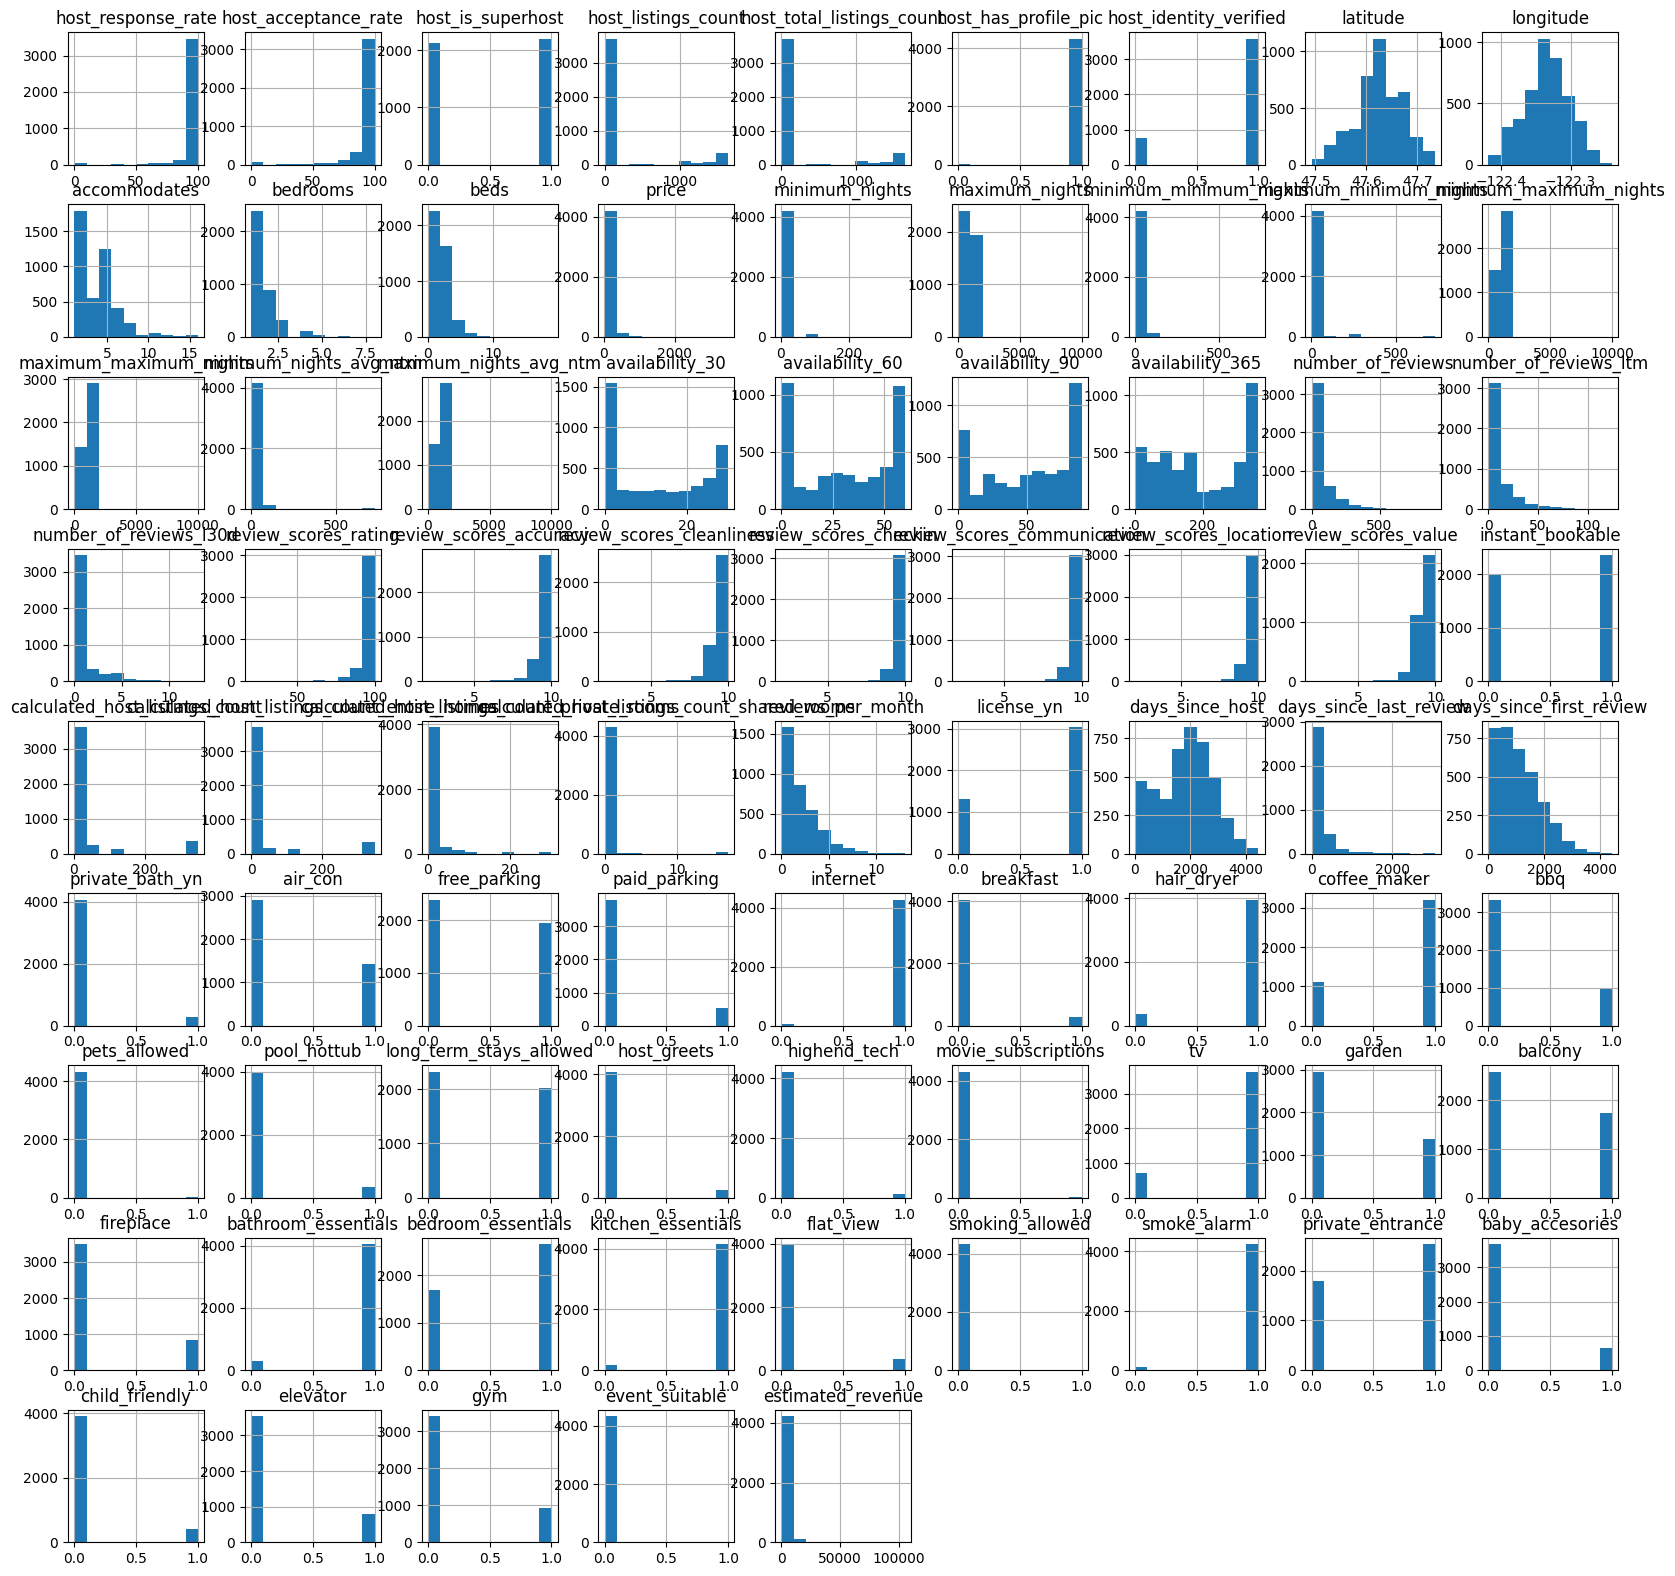

In [341]:
# Plotting the distribution of numerical and boolean values
listing_df.hist(figsize=(20,20));

In [342]:
# # Price distribution
# plt.rcParams["figure.figsize"] = (15,5)
# sns.displot(np.log(listing_df['price']+1),
#              color='orange')
# plt.title('Histogram of booking log price distribution')
# plt.xlabel('Log transformed booking price')

In [343]:
listing_df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,...,flat_view,smoking_allowed,smoke_alarm,private_entrance,baby_accesories,child_friendly,elevator,gym,event_suitable,estimated_revenue
0,within_a_day,100.0,78.0,1.0,2.0,2.0,1.0,1.0,47.61082,-122.29082,...,1,0,1,0,1,1,0,0,0,295.0
1,within_a_few_hours,100.0,89.0,1.0,8.0,8.0,1.0,1.0,47.55017,-122.31937,...,0,0,1,0,0,0,0,0,0,110.0
2,within_a_day,100.0,64.0,1.0,2.0,2.0,1.0,1.0,47.55539,-122.38474,...,0,0,1,1,0,0,0,0,0,4340.0
3,within_a_day,100.0,64.0,1.0,2.0,2.0,1.0,1.0,47.55624,-122.38598,...,0,0,1,1,0,0,0,0,0,625.0
4,within_a_few_hours,90.0,94.0,0.0,5.0,5.0,1.0,1.0,47.65479,-122.33652,...,0,0,1,0,0,0,0,0,0,400.0


## Question 1: 

- Which features are highly correlated with each other and/or with price?


In [344]:
# Correlation matrix to see the relationship between variables
corr_matrix = listing_df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

In [345]:
# Show all the columns that have correlation higher than 0.5
sol[(sol > 0.5)]

host_listings_count                          host_total_listings_count                      1.000000
calculated_host_listings_count               calculated_host_listings_count_entire_homes    0.998747
minimum_maximum_nights                       maximum_nights_avg_ntm                         0.984543
maximum_maximum_nights                       maximum_nights_avg_ntm                         0.981060
maximum_minimum_nights                       minimum_nights_avg_ntm                         0.964792
availability_60                              availability_90                                0.961392
minimum_maximum_nights                       maximum_maximum_nights                         0.956485
host_listings_count                          calculated_host_listings_count_entire_homes    0.925889
host_total_listings_count                    calculated_host_listings_count_entire_homes    0.925889
host_listings_count                          calculated_host_listings_count                

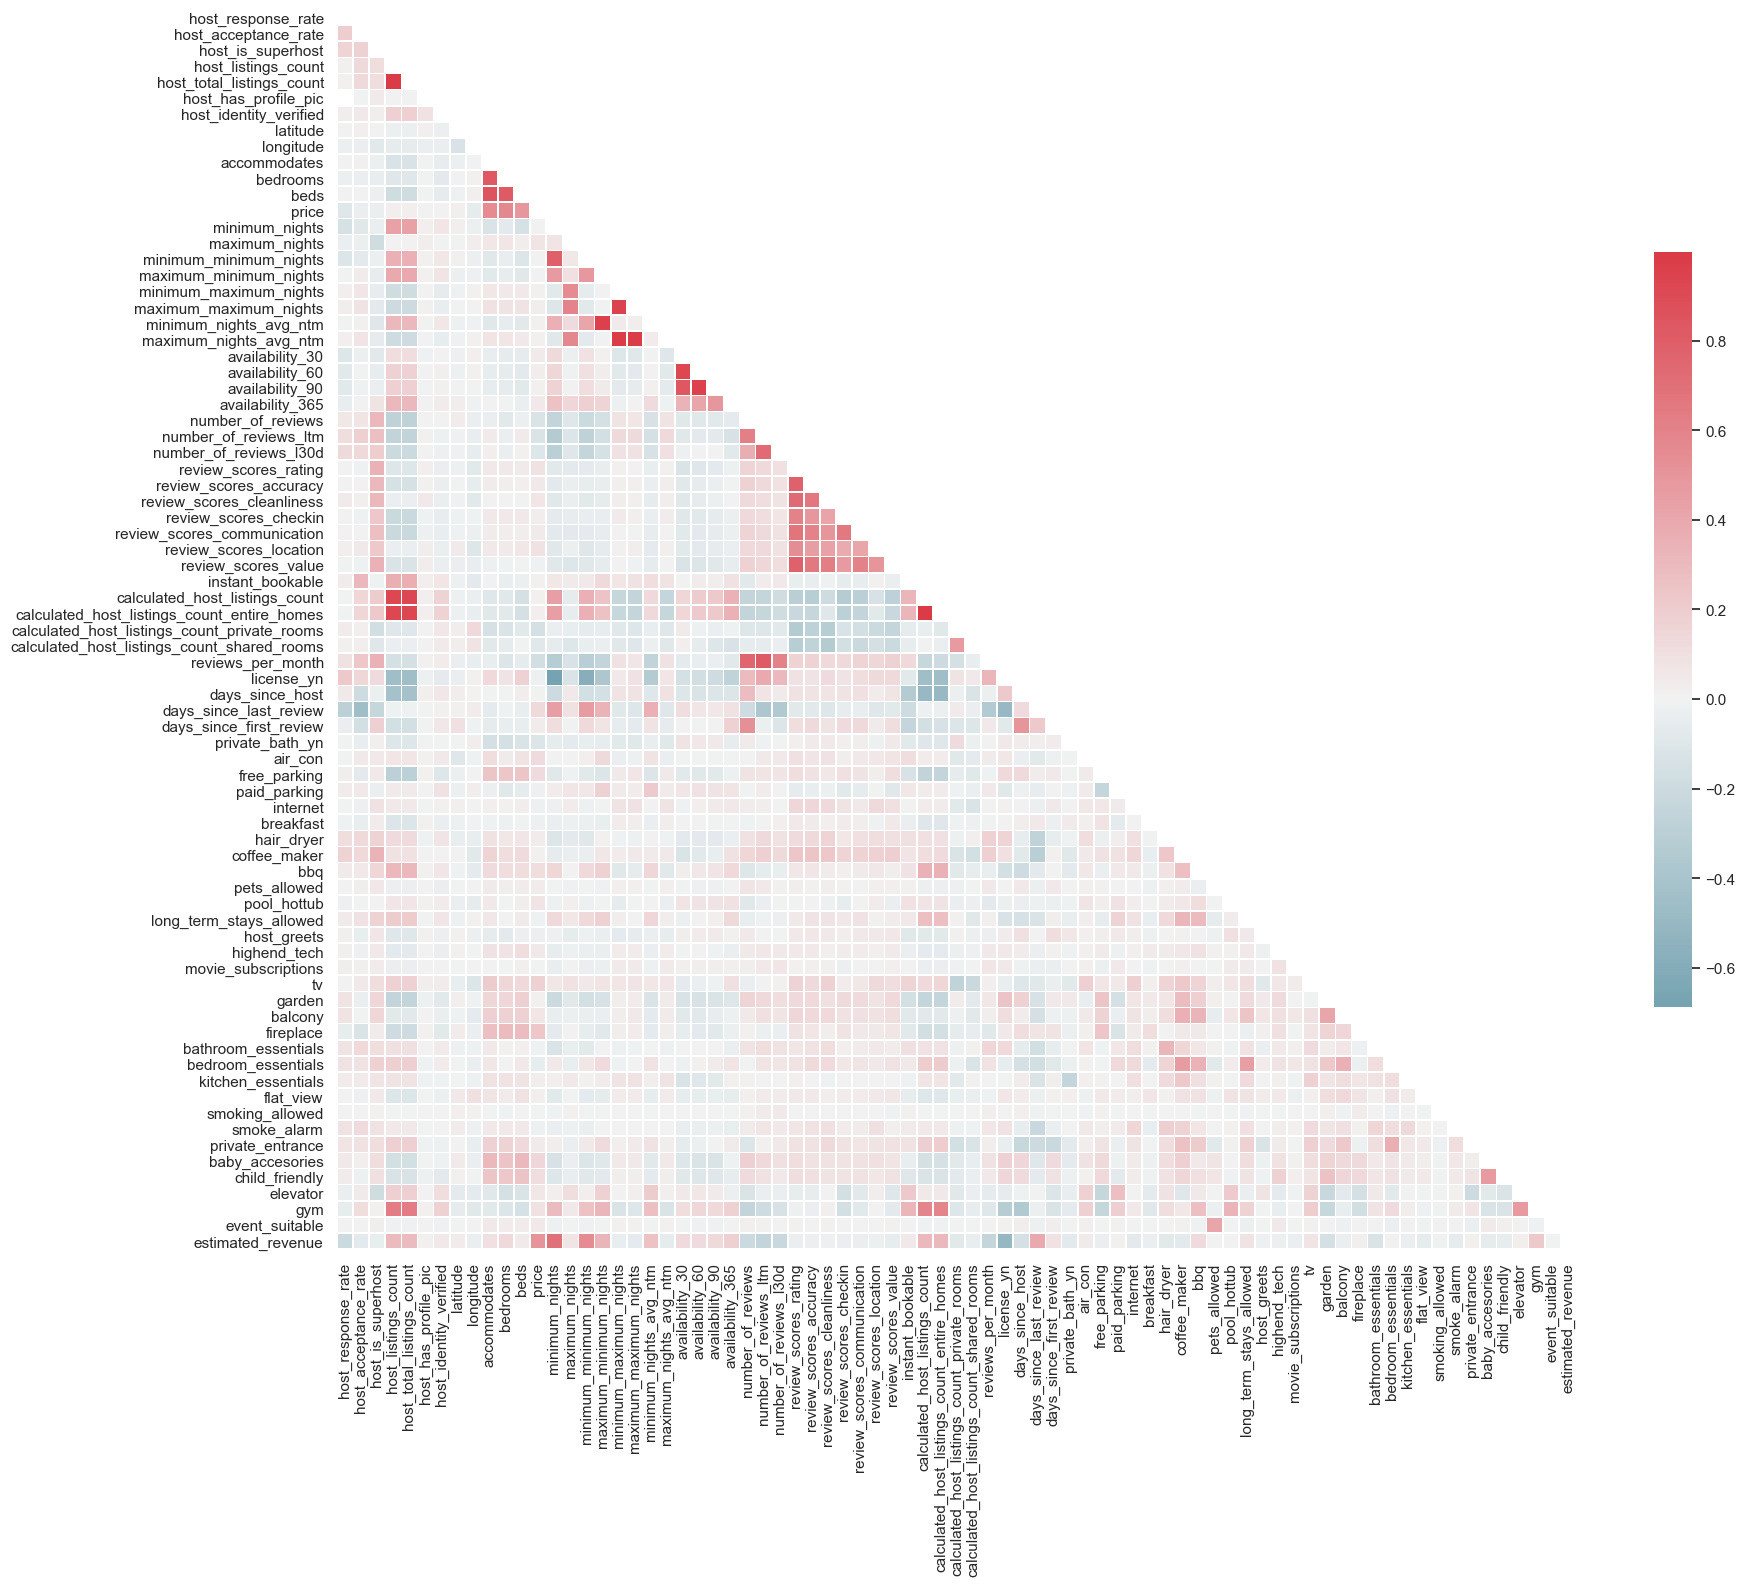

In [346]:
plot_heatmap(listing_df, figsize=(20,20))

- Number of people that the property can accommodate, the number of bedrooms, and the number of beds are highly correlated with each other. Although they are also all highly correlated with the price (our target variable), to reduce the multicollinearity, we will remove beds and bedrooms from the dataset. The number of people who can be accommodated would be more relevant to the guests than the other features. 
- __host total listings count__  and  __host listing count__  variables are correlated with __calculated host listings count__. We will keep the  __calculated host listings count__. variable and drop the others.

In [347]:
# Drop the values that are correlated to each other
listing_df = listing_df.drop(['beds', 'bedrooms','host_total_listings_count', 'host_listings_count'], axis = 1)

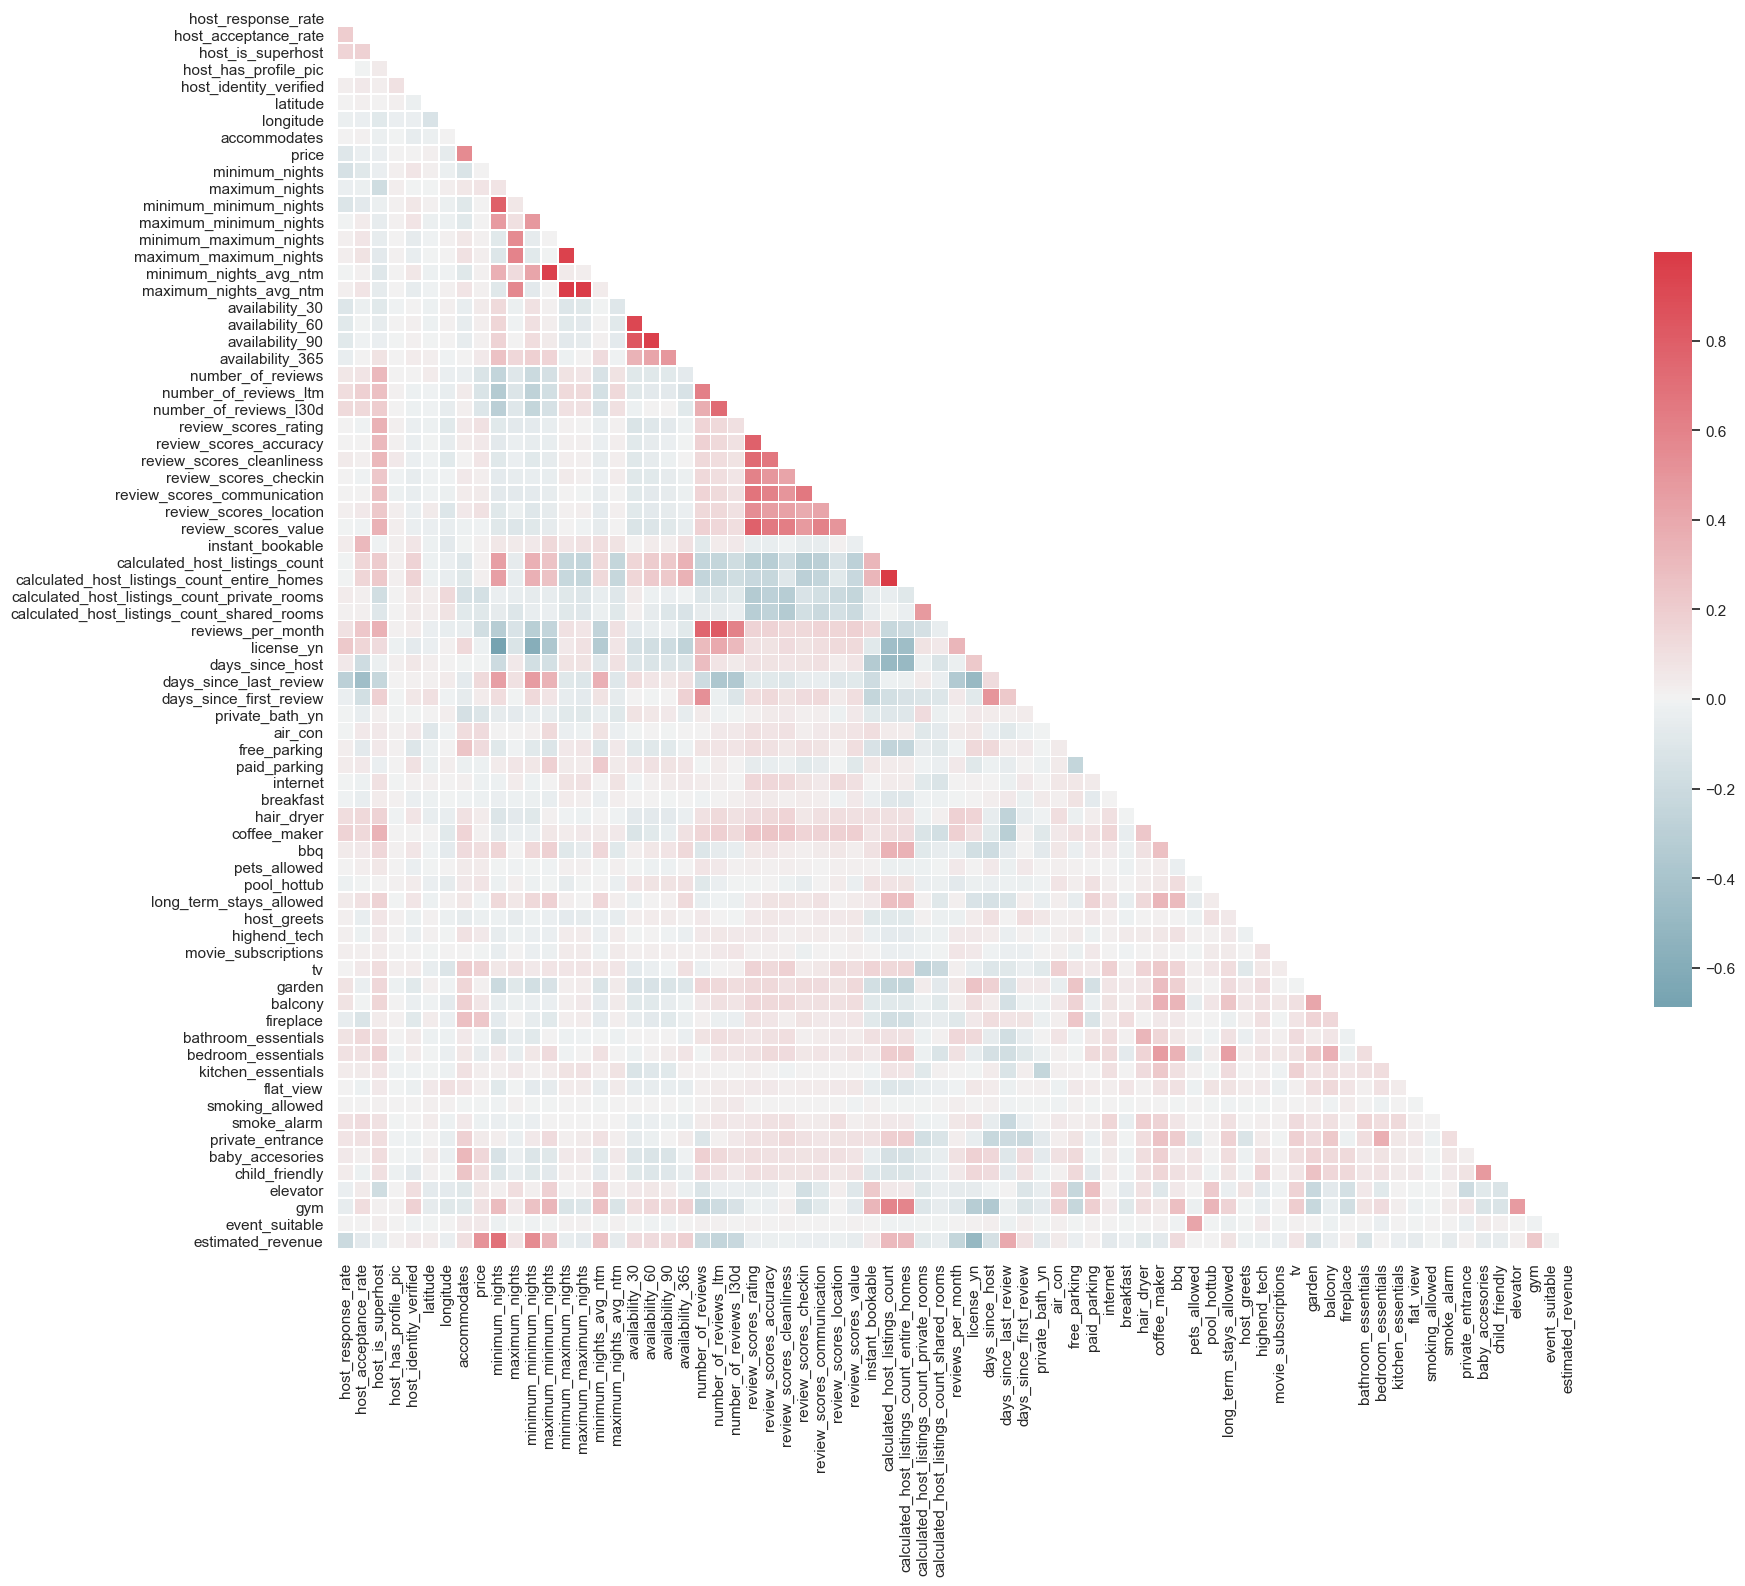

In [348]:
plot_heatmap(listing_df, figsize=(20,20))

# Question 2: 
    
- Do reviews have any effect on the price?
- Which factors affect the overall rating? Is it profitable to have a high rating?

In [349]:
# Show the top 5 listings that have the highest estimated revenue
(listing_df[['number_of_reviews','review_scores_rating', 'minimum_nights','accommodates','estimated_revenue']]
 .query("number_of_reviews > 0")
 .sort_values('estimated_revenue', ascending=False).head())

,number_of_reviews,review_scores_rating,minimum_nights,accommodates,estimated_revenue
1116,10,70.0,100,5,90000.0
264,11,91.0,30,6,45000.0
1183,69,96.0,30,3,39120.0
973,25,93.0,30,8,32370.0
1386,22,99.0,182,4,29120.0


In [350]:
# Show the top 5 listings that was advertised for 30days of stay and have the highest estimated revenue 
(listing_df[['number_of_reviews','review_scores_rating', 'minimum_nights','accommodates','estimated_revenue']]
 .query("number_of_reviews > 0 and minimum_nights <30")
 .sort_values('estimated_revenue', ascending=False).head())

,number_of_reviews,review_scores_rating,minimum_nights,accommodates,estimated_revenue
2053,20,99.0,29,12,17081.0
137,70,96.0,25,7,6775.0
1683,19,99.0,10,6,6750.0
1827,3,100.0,10,8,6500.0
1162,287,100.0,28,6,6160.0


In [351]:
# Show correlatation between estimated revenue and reviews 
(listing_df[['minimum_nights','number_of_reviews','estimated_revenue','review_scores_rating']]
 .query("number_of_reviews > 0")
 .corr())

,minimum_nights,number_of_reviews,estimated_revenue,review_scores_rating
minimum_nights,1.000000,-0.187925,0.641146,-0.080721
number_of_reviews,-0.187925,1.000000,-0.152691,0.159541
estimated_revenue,0.641146,-0.152691,1.000000,-0.037708
review_scores_rating,-0.080721,0.159541,-0.037708,1.000000


- Looking at the top 5 revenue listings, we see that the top earners host their place for at least a month. And short term listings have lower revenue than long-term listings. 
- Revenue is correlated with the number of nights the listing is advertised. However, score rating and the number of reviews do not seem to have any impact on the revenue of the listing.

## Question 3:

What are the most common property and room types that are listed? 
How are the prices distributed amongst them?

In [354]:
# Log transfrom price variable for better visualisation
listing_df["log_price"] =  np.log(listing_df.price)

<AxesSubplot:xlabel='log_price', ylabel='property_type'>

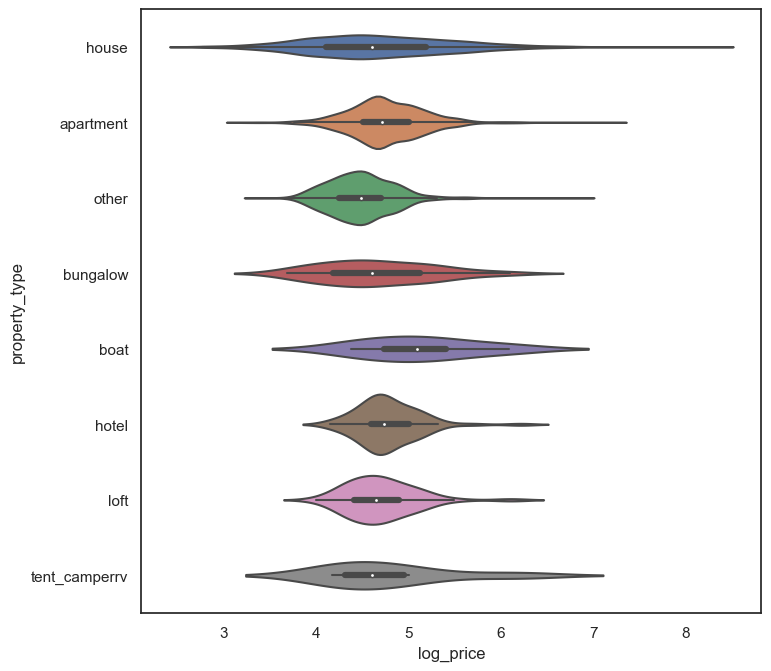

In [313]:
plt.rcParams['figure.figsize'] = [8, 8]
sns.violinplot(x="log_price", y="property_type", data=listing_df)

On average, by looking at the prices of property types, boats seem to be the most expensive option and the private room in a guest suite is the cheapest option on these listings. The variation also seems to be the highest in house prices as compared to the other property types. 

<AxesSubplot:xlabel='log_price', ylabel='room_type'>

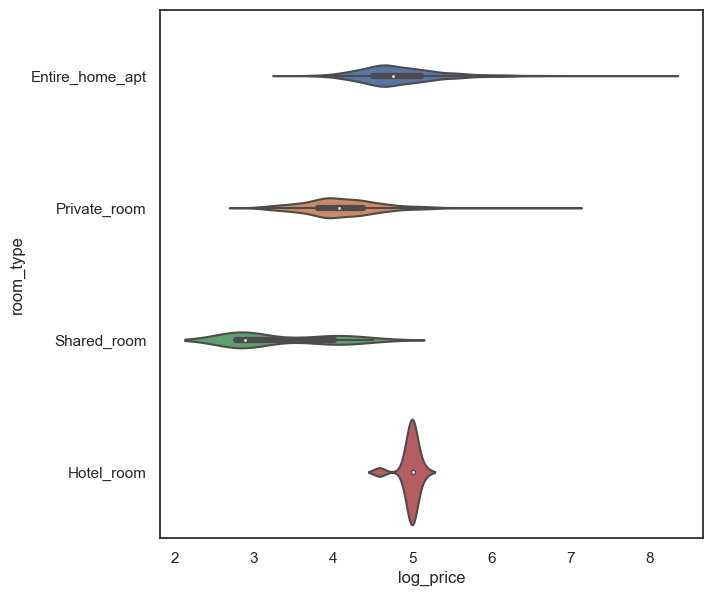

In [314]:
plt.rcParams['figure.figsize'] = [7, 7]
sns.violinplot(x="log_price", y="room_type", data=listing_df)

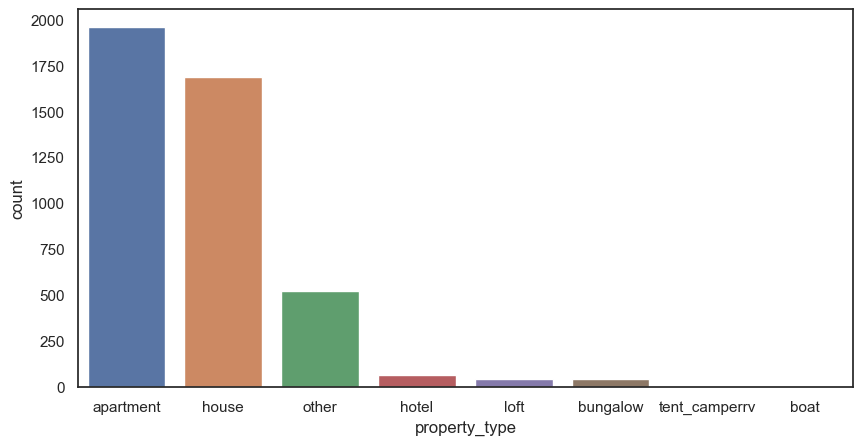

In [315]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.countplot(x = 'property_type',
              data = listing_df,
              order = listing_df['property_type'].value_counts().index)
plt.show()

The most popular listing property types are apartments and houses in Seattle Airbnb.

Create dummies from the categorical variables and drop all the variables that will not be used when building a model.

In [355]:
cat_cols = ['host_response_time', 'room_type', 'property_type']

final_df = create_dummy_cols(listing_df, cat_cols, dummy_na=False)

In [356]:
final_df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,price,minimum_nights,...,room_type_Shared_room,property_type_boat,property_type_bungalow,property_type_guest suite,property_type_hotel,property_type_house,property_type_loft,property_type_other,property_type_room,property_type_tent_camperrv
count,3761.000000,3960.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,...,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000,4335.000000
mean,95.812550,92.821970,0.508189,0.997693,0.826067,47.624903,-122.334422,3.662745,132.684890,14.692964,...,0.006690,0.001384,0.010150,0.117416,0.014994,0.389619,0.010611,0.001384,0.001153,0.001615
std,13.585984,16.499753,0.499991,0.047979,0.379096,0.046128,0.032517,2.258498,115.763519,20.761275,...,0.081526,0.037182,0.100246,0.321953,0.121543,0.487720,0.102475,0.037182,0.033946,0.040156
min,0.000000,0.000000,0.000000,0.000000,0.000000,47.492650,-122.418760,1.000000,16.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97.000000,94.000000,0.000000,1.000000,1.000000,47.606510,-122.355250,2.000000,77.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,99.000000,1.000000,1.000000,1.000000,47.619400,-122.334560,3.000000,106.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,100.000000,1.000000,1.000000,1.000000,47.660025,-122.312795,4.000000,150.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,1.000000,1.000000,1.000000,47.734890,-122.240310,16.000000,3503.000000,365.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Conclusion:

In this article, we had a look at which characteristics affect the price listings set by the hosts and the estimated revenue they make in Seattle. Equally, many other questions could be explored around the features of the listings such as amenities, area, etc. Here we focused on data cleaning and exploratory analysis, which are the essential steps before building any model. 

Our key takeaways of the questions we explored were:
- Higher the number of people a listing can accommodate, the more likely it that the host will make higher estimated revenue.
- Surprisingly, ratings and the number of reviews do not have much impact on the estimated revenue. However, it is still nice to give a review for future hosts to get a better feel of the listing. 
- Apartments and houses are the most common property types in these listings. The most expensive option turned out to be boat listings.